# Emotion Analysis — Philippine Airlines Reddit Data

## Overview

This notebook applies our trained **6-class emotion classifier** to analyze Reddit discussions about Philippine airlines (Cebu Pacific and Philippine Airlines).

### Pipeline

```
CSV Data -> Load & Clean -> Combine Text Fields -> Batch Inference -> Analytics -> Export
```

### Data Sources

| Dataset | Source | Description |
|---------|--------|-------------|
| `cebupac_data.csv` | r/CebuPacificAir | Reddit posts/comments about Cebu Pacific |
| `phairlines_data.csv` | r/philippineairlines | Reddit posts/comments about PAL |

### Emotion Classes

| Label | Emotion | Description |
|-------|---------|-------------|
| 0 | `sadness` | Feeling of sorrow or unhappiness |
| 1 | `joy` | Feeling of happiness or pleasure |
| 2 | `love` | Feeling of deep affection |
| 3 | `anger` | Feeling of strong displeasure |
| 4 | `fear` | Feeling of being afraid |
| 5 | `surprise` | Feeling of astonishment |

<br>

---

## Step 0 — Environment Setup

In [1]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

import os
import re
import json
import warnings
from typing import List, Dict, Union, Optional
from dataclasses import dataclass, asdict
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"{'='*60}")
print(f"EMOTION ANALYSIS — AIRLINE REDDIT DATA")
print(f"{'='*60}")
print(f"\n[OK] Environment ready.")
print(f"     Device: {DEVICE}")
print(f"     PyTorch: {torch.__version__}")
print(f"     Pandas: {pd.__version__}")

EMOTION ANALYSIS — AIRLINE REDDIT DATA

[OK] Environment ready.
     Device: cuda
     PyTorch: 2.6.0+cu124
     Pandas: 2.3.2


<br>

---

## Step 1 — Configuration

Set paths to your data and model artifacts.

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# ---------------------------------
# Data Paths (UPDATE THESE)
# ---------------------------------
DATA_DIR = r"C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset"

DATASETS = {
    "cebu_pacific": {
        "path": os.path.join(DATA_DIR, "cebupac_data.csv"),
        "name": "Cebu Pacific",
        "subreddit": "r/CebuPacificAir"
    },
    "philippine_airlines": {
        "path": os.path.join(DATA_DIR, "phairlines_data.csv"),
        "name": "Philippine Airlines",
        "subreddit": "r/philippineairlines"
    }
}

# ---------------------------------
# Model Artifacts Path
# ---------------------------------
ARTIFACT_DIR = "./emotion_model_artifacts"

# ---------------------------------
# Output Configuration
# ---------------------------------
OUTPUT_DIR = "./emotion_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------
# Processing Configuration
# ---------------------------------
BATCH_SIZE = 32
MAX_SEQ_LENGTH = 128

print(f"\nData Directory: {DATA_DIR}")
print(f"Artifact Directory: {ARTIFACT_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"\nBatch Size: {BATCH_SIZE}")
print(f"Max Sequence Length: {MAX_SEQ_LENGTH}")


Data Directory: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset
Artifact Directory: ./emotion_model_artifacts
Output Directory: ./emotion_results

Batch Size: 32
Max Sequence Length: 128


<br>

---

## Step 2 — Load Model Artifacts

In [3]:
# ============================================================================
# LOAD MODEL ARTIFACTS
# ============================================================================

print(f"\n{'='*60}")
print("LOADING MODEL ARTIFACTS")
print(f"{'='*60}")

# ---------------------------------
# 2.1 Load Configuration
# ---------------------------------
config_path = os.path.join(ARTIFACT_DIR, "config.json")
with open(config_path, "r") as f:
    config = json.load(f)

MODEL_NAME = config["model_name"]
NUM_CLASSES = config["num_classes"]
EMOTION_LABELS = {int(k): v for k, v in config["label_to_emotion"].items()}

print(f"\n[1] Config loaded:")
print(f"    Model: {MODEL_NAME}")
print(f"    Classes: {NUM_CLASSES}")
print(f"    Labels: {list(EMOTION_LABELS.values())}")

# ---------------------------------
# 2.2 Load Scaler
# ---------------------------------
scaler_path = os.path.join(ARTIFACT_DIR, "scaler.joblib")
scaler = joblib.load(scaler_path)
print(f"[2] Scaler loaded")

# ---------------------------------
# 2.3 Load Classifier
# ---------------------------------
classifier_path = os.path.join(ARTIFACT_DIR, "classifier.joblib")
classifier = joblib.load(classifier_path)
print(f"[3] Classifier loaded")

# ---------------------------------
# 2.4 Load RoBERTa Model
# ---------------------------------
print(f"[4] Loading RoBERTa from HuggingFace...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
embedding_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
embedding_model.eval()
print(f"    RoBERTa loaded successfully.")

print(f"\n{'='*60}")
print("All artifacts loaded. Ready for inference.")
print(f"{'='*60}")


LOADING MODEL ARTIFACTS

[1] Config loaded:
    Model: bhadresh-savani/roberta-base-emotion
    Classes: 6
    Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
[2] Scaler loaded
[3] Classifier loaded
[4] Loading RoBERTa from HuggingFace...


Some weights of RobertaModel were not initialized from the model checkpoint at bhadresh-savani/roberta-base-emotion and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    RoBERTa loaded successfully.

All artifacts loaded. Ready for inference.


<br>

---

## Step 3 — Define Emotion Classifier

Classifier class with:
- Progress bar for batch processing
- Graceful handling of empty/missing text
- Memory-efficient batching

In [4]:
# ============================================================================
# EMOTION CLASSIFIER CLASS
# ============================================================================

class EmotionClassifier:
    """
    End-to-end emotion classification pipeline optimized for batch processing.
    """
    
    LABEL_NAMES = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }
    
    LABEL_COLORS = {
        "sadness": "#3498db",    # Blue
        "joy": "#f1c40f",        # Yellow
        "love": "#e74c3c",       # Red
        "anger": "#c0392b",      # Dark Red
        "fear": "#9b59b6",       # Purple
        "surprise": "#1abc9c"    # Teal
    }
    
    def __init__(
        self,
        tokenizer,
        embedding_model,
        scaler,
        classifier,
        max_length: int = 128,
        device: str = "cpu"
    ):
        self.tokenizer = tokenizer
        self.embedding_model = embedding_model
        self.scaler = scaler
        self.classifier = classifier
        self.max_length = max_length
        self.device = device
        self.embedding_model.eval()
    
    def _normalize_text(self, text: str) -> str:
        """
        Apply minimal text normalization.
        Handles None, NaN, and non-string inputs gracefully.
        """
        if text is None or (isinstance(text, float) and np.isnan(text)):
            return ""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = re.sub(r"\s+", " ", text).strip()
        return text
    
    def _get_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """
        Extract RoBERTa embeddings for a single batch.
        """
        texts = [t if t else "[empty]" for t in texts]
        
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.embedding_model(**encoded)
            hidden_states = outputs.last_hidden_state
            embeddings = hidden_states.mean(dim=1)
        
        return embeddings.cpu().numpy()
    
    def predict_dataframe(
        self,
        texts: List[str],
        batch_size: int = 32,
        show_progress: bool = True
    ) -> pd.DataFrame:
        """
        Predict emotion for a list of texts and return as DataFrame.
        
        Args:
            texts: List of input strings
            batch_size: Number of texts per batch
            show_progress: Show progress bar
        
        Returns:
            DataFrame with predictions and probabilities
        """
        normalized = [self._normalize_text(t) for t in texts]
        
        all_embeddings = []
        n_batches = (len(normalized) + batch_size - 1) // batch_size
        
        iterator = range(0, len(normalized), batch_size)
        if show_progress:
            iterator = tqdm(iterator, total=n_batches, desc="Extracting embeddings")
        
        for i in iterator:
            batch = normalized[i:i + batch_size]
            embeddings = self._get_embeddings_batch(batch)
            all_embeddings.append(embeddings)
        
        all_embeddings = np.vstack(all_embeddings)
        
        if show_progress:
            print("Scaling embeddings...")
        scaled = self.scaler.transform(all_embeddings)
        
        if show_progress:
            print("Classifying...")
        predictions = self.classifier.predict(scaled)
        probabilities = self.classifier.predict_proba(scaled)
        
        results = pd.DataFrame({
            "text_original": texts,
            "text_normalized": normalized,
            "emotion_label": predictions,
            "emotion_name": [self.LABEL_NAMES[p] for p in predictions],
            "confidence": [probabilities[i, p] for i, p in enumerate(predictions)],
            "prob_sadness": probabilities[:, 0],
            "prob_joy": probabilities[:, 1],
            "prob_love": probabilities[:, 2],
            "prob_anger": probabilities[:, 3],
            "prob_fear": probabilities[:, 4],
            "prob_surprise": probabilities[:, 5]
        })
        
        if show_progress:
            print(f"Processed {len(texts):,} texts")
        
        return results


# Instantiate the classifier
emotion_clf = EmotionClassifier(
    tokenizer=tokenizer,
    embedding_model=embedding_model,
    scaler=scaler,
    classifier=classifier,
    max_length=MAX_SEQ_LENGTH,
    device=DEVICE
)

print("\nEmotionClassifier instantiated and ready.")


EmotionClassifier instantiated and ready.


<br>

---

## Step 4 — Load and Prepare Reddit Data

Load the CSV files and prepare text for analysis:
- Combine `title` and `body` fields
- Handle missing values
- Filter empty texts

In [5]:
# ============================================================================
# LOAD AND PREPARE REDDIT DATA
# ============================================================================

def load_reddit_data(file_path: str, dataset_name: str) -> pd.DataFrame:
    """
    Load Reddit CSV data and prepare for emotion analysis.
    
    Args:
        file_path: Path to CSV file
        dataset_name: Name identifier for the dataset
    
    Returns:
        Prepared DataFrame
    """
    print(f"\nLoading: {file_path}")
    
    df = pd.read_csv(file_path, encoding='utf-8')
    print(f"   Raw rows: {len(df):,}")
    print(f"   Columns: {list(df.columns)}")
    
    df["dataset"] = dataset_name
    
    def combine_text(row):
        title = row.get("title", "") or ""
        body = row.get("body", "") or ""
        
        if pd.isna(title):
            title = ""
        if pd.isna(body):
            body = ""
        
        parts = [str(title).strip(), str(body).strip()]
        parts = [p for p in parts if p]
        
        return " ".join(parts)
    
    df["combined_text"] = df.apply(combine_text, axis=1)
    
    df = df[df["combined_text"].str.len() > 0].copy()
    print(f"   After filtering empty: {len(df):,} rows")
    
    if "created_utc" in df.columns:
        try:
            df["created_datetime"] = pd.to_datetime(df["created_utc"], errors='coerce')
        except:
            pass
    
    return df


print(f"\n{'='*60}")
print("LOADING REDDIT DATASETS")
print(f"{'='*60}")

all_data = {}
for key, info in DATASETS.items():
    if os.path.exists(info["path"]):
        all_data[key] = load_reddit_data(info["path"], info["name"])
    else:
        print(f"\nFile not found: {info['path']}")

if all_data:
    df_combined = pd.concat(all_data.values(), ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL: {len(df_combined):,} rows loaded")
    print(f"{'='*60}")
else:
    print("\nNo data loaded. Please check file paths.")


LOADING REDDIT DATASETS

Loading: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset\cebupac_data.csv
   Raw rows: 2,285
   Columns: ['post_id', 'comment_id', 'parent_id', 'level', 'level_path', 'type', 'title', 'body', 'author', 'score', 'upvote_ratio', 'num_comments', 'created_utc', 'url', 'permalink', 'is_original_content', 'is_self', 'over_18', 'spoiler', 'stickied']
   After filtering empty: 2,285 rows

Loading: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset\phairlines_data.csv
   Raw rows: 707
   Columns: ['post_id', 'comment_id', 'parent_id', 'level', 'level_path', 'type', 'title', 'body', 'author', 'score', 'upvote_ratio', 'num_comments', 'created_utc', 'url', 'permalink', 'is_original_content', 'is_self', 'over_18', 'spoiler', 'stickied']
   After filtering empty: 707 rows

TOTAL: 2,992 rows loaded


<br>

---

## Step 5 — Preview Data

In [6]:
# ============================================================================
# PREVIEW DATA
# ============================================================================

print(f"\n{'='*60}")
print("DATA PREVIEW")
print(f"{'='*60}")

print("\nDataset Breakdown:")
print(df_combined["dataset"].value_counts().to_string())

if "type" in df_combined.columns:
    print("\nContent Type Breakdown:")
    print(df_combined["type"].value_counts().to_string())

print("\nSample Combined Texts:")
print("-" * 60)
for idx, row in df_combined.head(5).iterrows():
    text = row["combined_text"][:100]
    print(f"[{row['dataset']}] {text}...")
    print()


DATA PREVIEW

Dataset Breakdown:
dataset
Cebu Pacific           2285
Philippine Airlines     707

Content Type Breakdown:
type
comment    2444
post        548

Sample Combined Texts:
------------------------------------------------------------
[Cebu Pacific] Travel Tax not reflected in Fare Breakdown Hi, just paid the travel tax sa Ceb Pac for our flight th...

[Cebu Pacific] Mas mura to pay Travel Tax sa airport, you save the processing fee. Also pag may nangyari sa flight ...

[Cebu Pacific] Prepare mo nalang siguro yung receipt for your payment sa Travel Tax. Check-in counter staff should ...

[Cebu Pacific] How legit is this travel fund? Planning to book a flight with cebu pacific and i've seen posts that ...

[Cebu Pacific] Travel fund is legit. Your counterparty however, may not be....



<br>

---

## Step 6 — Run Emotion Inference

Process all texts through the classifier.

In [7]:
# ============================================================================
# RUN EMOTION INFERENCE
# ============================================================================

print(f"\n{'='*60}")
print("RUNNING EMOTION INFERENCE")
print(f"{'='*60}")
print(f"\nProcessing {len(df_combined):,} texts...\n")

start_time = datetime.now()

predictions_df = emotion_clf.predict_dataframe(
    texts=df_combined["combined_text"].tolist(),
    batch_size=BATCH_SIZE,
    show_progress=True
)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print(f"\nTime elapsed: {duration:.1f} seconds")
print(f"Speed: {len(df_combined) / duration:.1f} texts/second")


RUNNING EMOTION INFERENCE

Processing 2,992 texts...



Extracting embeddings:   0%|          | 0/94 [00:00<?, ?it/s]

Scaling embeddings...
Classifying...
Processed 2,992 texts

Time elapsed: 12.4 seconds
Speed: 240.9 texts/second


In [8]:
# ============================================================================
# MERGE PREDICTIONS WITH ORIGINAL DATA
# ============================================================================

df_results = df_combined.copy()
df_results["emotion_label"] = predictions_df["emotion_label"].values
df_results["emotion_name"] = predictions_df["emotion_name"].values
df_results["emotion_confidence"] = predictions_df["confidence"].values
df_results["prob_sadness"] = predictions_df["prob_sadness"].values
df_results["prob_joy"] = predictions_df["prob_joy"].values
df_results["prob_love"] = predictions_df["prob_love"].values
df_results["prob_anger"] = predictions_df["prob_anger"].values
df_results["prob_fear"] = predictions_df["prob_fear"].values
df_results["prob_surprise"] = predictions_df["prob_surprise"].values

print(f"\nPredictions merged with original data")
print(f"Result shape: {df_results.shape}")


Predictions merged with original data
Result shape: (2992, 32)


<br>

---

## Step 7 — Emotion Analytics

Analyze the distribution of emotions across datasets.

In [9]:
# ============================================================================
# OVERALL EMOTION DISTRIBUTION
# ============================================================================

print(f"\n{'='*60}")
print("EMOTION ANALYSIS RESULTS")
print(f"{'='*60}")

print("\nOverall Emotion Distribution:")
print("-" * 40)

emotion_counts = df_results["emotion_name"].value_counts()
emotion_pcts = df_results["emotion_name"].value_counts(normalize=True) * 100

label_order = ["sadness", "joy", "love", "anger", "fear", "surprise"]

for label in label_order:
    if label in emotion_counts.index:
        count = emotion_counts[label]
        pct = emotion_pcts[label]
        bar = "#" * int(pct / 2)
        print(f"{label:>12}: {count:>6,} ({pct:>5.1f}%) {bar}")


EMOTION ANALYSIS RESULTS

Overall Emotion Distribution:
----------------------------------------
     sadness:     84 (  2.8%) #
         joy:  2,070 ( 69.2%) ##################################
        love:     12 (  0.4%) 
       anger:    459 ( 15.3%) #######
        fear:    360 ( 12.0%) ######
    surprise:      7 (  0.2%) 


In [10]:
# ============================================================================
# EMOTION BY DATASET (AIRLINE)
# ============================================================================

print("\nEmotion by Airline:")
print("-" * 60)

crosstab = pd.crosstab(
    df_results["dataset"],
    df_results["emotion_name"],
    normalize="index"
) * 100

crosstab = crosstab.reindex(columns=[c for c in label_order if c in crosstab.columns])

print(crosstab.round(1).to_string())

print("\nDominant Emotion by Airline:")
print("-" * 40)

for dataset in df_results["dataset"].unique():
    subset = df_results[df_results["dataset"] == dataset]
    dominant = subset["emotion_name"].mode()[0]
    dominant_pct = (subset["emotion_name"] == dominant).mean() * 100
    total = len(subset)
    print(f"{dataset}: {dominant} ({dominant_pct:.1f}%) [n={total:,}]")


Emotion by Airline:
------------------------------------------------------------
emotion_name         sadness   joy  love  anger  fear  surprise
dataset                                                        
Cebu Pacific             2.8  70.6   0.4   15.2  10.9       0.2
Philippine Airlines      3.0  64.6   0.4   15.8  15.8       0.3

Dominant Emotion by Airline:
----------------------------------------
Cebu Pacific: joy (70.6%) [n=2,285]
Philippine Airlines: joy (64.6%) [n=707]


In [11]:
# ============================================================================
# EMOTION BY CONTENT TYPE (POST VS COMMENT)
# ============================================================================

if "type" in df_results.columns:
    print("\nEmotion by Content Type:")
    print("-" * 60)
    
    crosstab_type = pd.crosstab(
        df_results["type"],
        df_results["emotion_name"],
        normalize="index"
    ) * 100
    
    crosstab_type = crosstab_type.reindex(columns=[c for c in label_order if c in crosstab_type.columns])
    print(crosstab_type.round(1).to_string())


Emotion by Content Type:
------------------------------------------------------------
emotion_name  sadness   joy  love  anger  fear  surprise
type                                                    
comment           3.3  69.8   0.5   15.9  10.4       0.2
post              0.7  66.4   0.2   12.8  19.3       0.5


In [12]:
# ============================================================================
# SENTIMENT GROUPING (POSITIVE / NEGATIVE / NEUTRAL)
# ============================================================================

print("\nSentiment Grouping:")
print("-" * 40)

def map_sentiment(emotion):
    if emotion in ["joy", "love"]:
        return "positive"
    elif emotion in ["sadness", "anger", "fear"]:
        return "negative"
    else:
        return "neutral"

df_results["sentiment"] = df_results["emotion_name"].apply(map_sentiment)

sentiment_counts = df_results["sentiment"].value_counts()
sentiment_pcts = df_results["sentiment"].value_counts(normalize=True) * 100

for sentiment in ["positive", "negative", "neutral"]:
    if sentiment in sentiment_counts.index:
        count = sentiment_counts[sentiment]
        pct = sentiment_pcts[sentiment]
        bar = "#" * int(pct / 2)
        print(f"{sentiment:>12}: {count:>6,} ({pct:>5.1f}%) {bar}")

print("\nSentiment by Airline:")
print("-" * 40)

sentiment_by_airline = pd.crosstab(
    df_results["dataset"],
    df_results["sentiment"],
    normalize="index"
) * 100

print(sentiment_by_airline.round(1).to_string())


Sentiment Grouping:
----------------------------------------
    positive:  2,082 ( 69.6%) ##################################
    negative:    903 ( 30.2%) ###############
     neutral:      7 (  0.2%) 

Sentiment by Airline:
----------------------------------------
sentiment            negative  neutral  positive
dataset                                         
Cebu Pacific             28.8      0.2      71.0
Philippine Airlines      34.7      0.3      65.1


<br>

---

## Step 8 — Visualizations

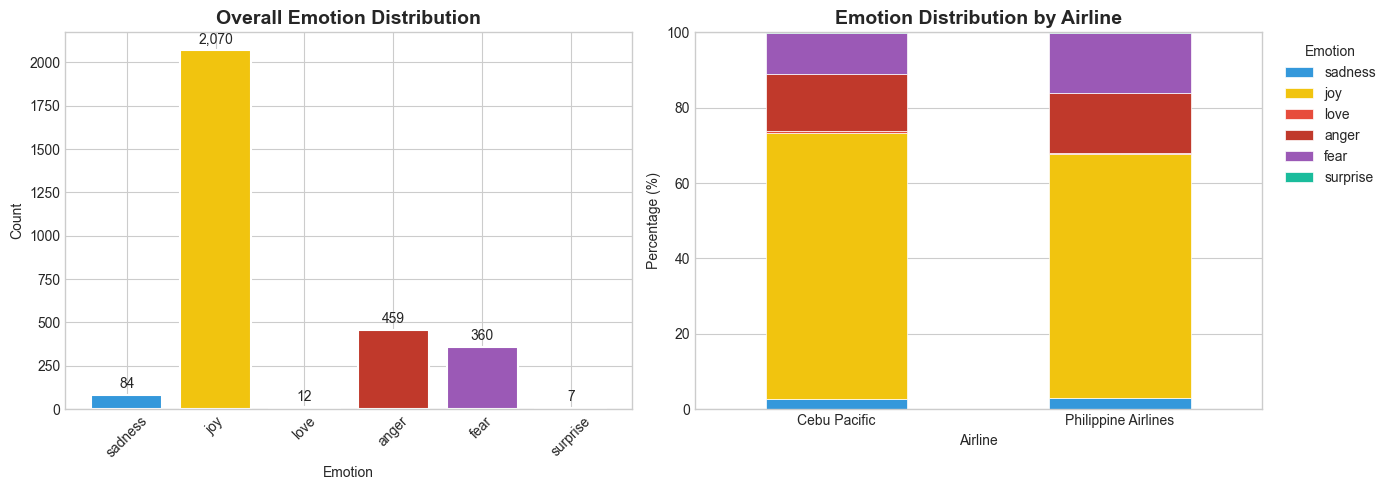


Chart saved to: ./emotion_results/emotion_distribution.png


In [13]:
# ============================================================================
# VISUALIZATION: EMOTION DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = [EmotionClassifier.LABEL_COLORS[l] for l in label_order]

# Plot 1: Overall Distribution
ax1 = axes[0]
counts = [emotion_counts.get(l, 0) for l in label_order]
bars = ax1.bar(label_order, counts, color=colors, edgecolor='white', linewidth=1.5)
ax1.set_title("Overall Emotion Distribution", fontsize=14, fontweight='bold')
ax1.set_xlabel("Emotion")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

for bar, count in zip(bars, counts):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{count:,}', ha='center', va='bottom', fontsize=10)

# Plot 2: By Airline (stacked percentage)
ax2 = axes[1]
crosstab_plot = crosstab.reindex(columns=label_order)
crosstab_plot.plot(kind='bar', stacked=True, ax=ax2, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_title("Emotion Distribution by Airline", fontsize=14, fontweight='bold')
ax2.set_xlabel("Airline")
ax2.set_ylabel("Percentage (%)")
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title="Emotion", bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "emotion_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nChart saved to: {OUTPUT_DIR}/emotion_distribution.png")

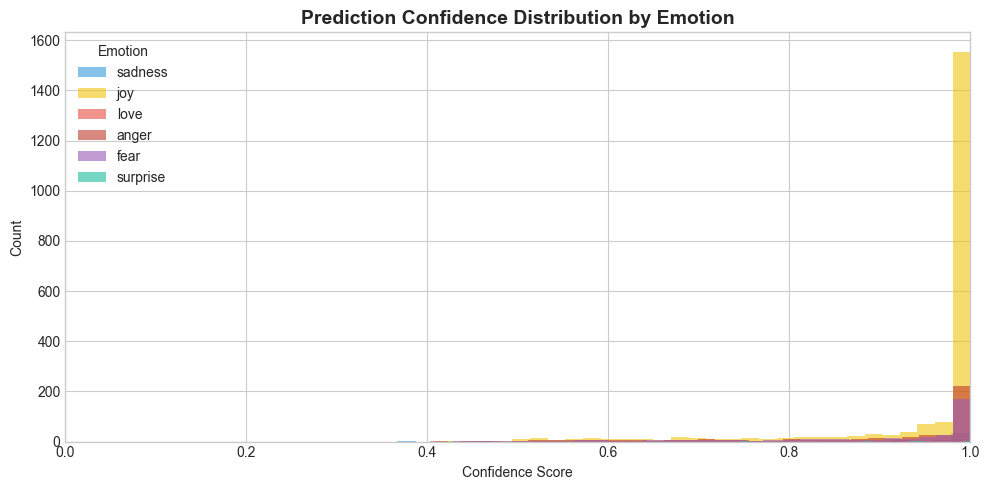

In [14]:
# ============================================================================
# VISUALIZATION: CONFIDENCE DISTRIBUTION
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 5))

for label in label_order:
    subset = df_results[df_results["emotion_name"] == label]["emotion_confidence"]
    if len(subset) > 0:
        ax.hist(subset, bins=30, alpha=0.6, label=label, 
                color=EmotionClassifier.LABEL_COLORS[label])

ax.set_title("Prediction Confidence Distribution by Emotion", fontsize=14, fontweight='bold')
ax.set_xlabel("Confidence Score")
ax.set_ylabel("Count")
ax.legend(title="Emotion")
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

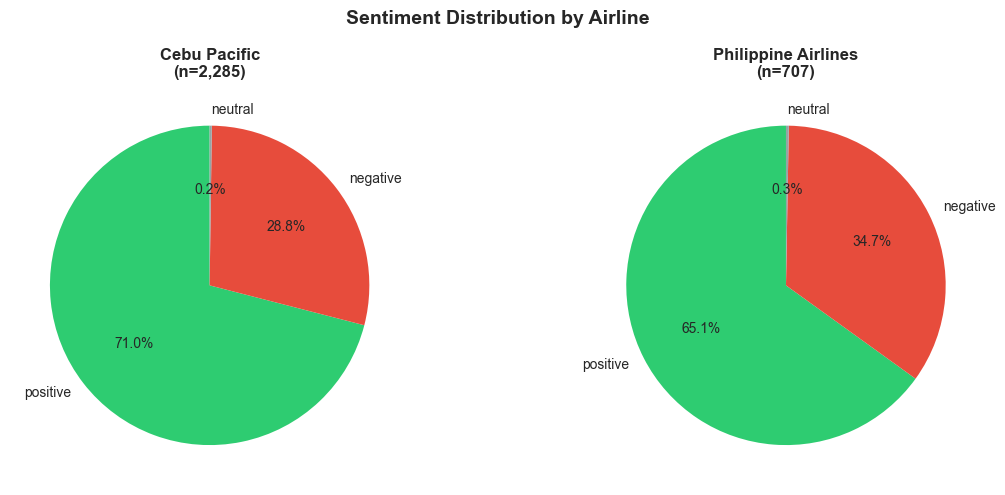

In [15]:
# ============================================================================
# VISUALIZATION: SENTIMENT PIE CHART
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sentiment_colors = {
    "positive": "#2ecc71",
    "negative": "#e74c3c",
    "neutral": "#95a5a6"
}

for idx, dataset in enumerate(df_results["dataset"].unique()):
    ax = axes[idx]
    subset = df_results[df_results["dataset"] == dataset]
    sentiment_data = subset["sentiment"].value_counts()
    
    colors_pie = [sentiment_colors[s] for s in sentiment_data.index]
    ax.pie(sentiment_data.values, labels=sentiment_data.index, autopct='%1.1f%%',
           colors=colors_pie, startangle=90)
    ax.set_title(f"{dataset}\n(n={len(subset):,})", fontsize=12, fontweight='bold')

plt.suptitle("Sentiment Distribution by Airline", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sentiment_by_airline.png"), dpi=150, bbox_inches='tight')
plt.show()

<br>

---

## Step 9 — Example Predictions

View sample texts for each emotion.

In [ ]:
# ============================================================================
# SAMPLE PREDICTIONS BY EMOTION
# ============================================================================

print(f"\n{'='*70}")
print("SAMPLE PREDICTIONS BY EMOTION")
print(f"{'='*70}")

for label in label_order:
    subset = df_results[df_results["emotion_name"] == label]
    
    if len(subset) == 0:
        continue
    
    top_examples = subset.nlargest(3, "emotion_confidence")
    
    print(f"\n{'-'*70}")
    print(f"{label.upper()} (n={len(subset):,})")
    print(f"{'-'*70}")
    
    for idx, row in top_examples.iterrows():
        text = row["combined_text"][:150]
        conf = row["emotion_confidence"]
        dataset = row["dataset"]
        print(f"\n[{dataset}] (conf: {conf:.1%})")
        print(f"   \"{text}...\"")

<br>

---

## Step 10 — Export Results

In [ ]:
# ============================================================================
# EXPORT RESULTS TO CSV
# ============================================================================

print(f"\n{'='*60}")
print("EXPORTING RESULTS")
print(f"{'='*60}")

# Export full results
full_output_path = os.path.join(OUTPUT_DIR, "emotion_results_full.csv")
df_results.to_csv(full_output_path, index=False, encoding='utf-8-sig')
print(f"\nFull results exported to: {full_output_path}")
print(f"   Rows: {len(df_results):,}")

# Export by dataset
for dataset_name in df_results["dataset"].unique():
    subset = df_results[df_results["dataset"] == dataset_name]
    filename = f"emotion_results_{dataset_name.lower().replace(' ', '_')}.csv"
    output_path = os.path.join(OUTPUT_DIR, filename)
    subset.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"{dataset_name}: {output_path} ({len(subset):,} rows)")

# Export summary statistics
summary = df_results.groupby(["dataset", "emotion_name"]).size().unstack(fill_value=0)
summary_path = os.path.join(OUTPUT_DIR, "emotion_summary.csv")
summary.to_csv(summary_path)
print(f"Summary statistics: {summary_path}")

In [ ]:
# ============================================================================
# EXPORT NEGATIVE SENTIMENT CONTENT (FOR REVIEW)
# ============================================================================

negative_content = df_results[df_results["sentiment"] == "negative"]
negative_content = negative_content.sort_values("emotion_confidence", ascending=False)

negative_output_path = os.path.join(OUTPUT_DIR, "negative_sentiment_for_review.csv")
negative_content.to_csv(negative_output_path, index=False, encoding='utf-8-sig')

print(f"\nNegative sentiment content exported for review: {negative_output_path}")
print(f"   Total negative items: {len(negative_content):,}")
print(f"   - sadness: {(negative_content['emotion_name'] == 'sadness').sum():,}")
print(f"   - anger: {(negative_content['emotion_name'] == 'anger').sum():,}")
print(f"   - fear: {(negative_content['emotion_name'] == 'fear').sum():,}")

<br>

---

## Summary

In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'='*70}")
print("EMOTION ANALYSIS SUMMARY")
print(f"{'='*70}")

print(f"\nDatasets Analyzed:")
for dataset in df_results["dataset"].unique():
    count = (df_results["dataset"] == dataset).sum()
    print(f"   - {dataset}: {count:,} items")

print(f"\nOverall Statistics:")
print(f"   - Total items analyzed: {len(df_results):,}")
print(f"   - Dominant emotion: {df_results['emotion_name'].mode()[0]}")
print(f"   - Positive sentiment rate: {(df_results['sentiment'] == 'positive').mean()*100:.1f}%")
print(f"   - Negative sentiment rate: {(df_results['sentiment'] == 'negative').mean()*100:.1f}%")
print(f"   - Average confidence: {df_results['emotion_confidence'].mean():.1%}")

print(f"\nOutput Files:")
for f in os.listdir(OUTPUT_DIR):
    fpath = os.path.join(OUTPUT_DIR, f)
    size = os.path.getsize(fpath) / 1024
    print(f"   - {f} ({size:.1f} KB)")

print(f"\n{'='*70}")
print("Analysis Complete!")
print(f"{'='*70}")